In [1]:
%tensorflow_version 1.x
import matplotlib.image as img
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from skimage.color import rgb2gray
from skimage import data
from skimage.util import random_noise
import math
import os
from skimage import io
from google.colab import drive
from scipy import misc
from scipy import ndimage 
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float

TensorFlow 1.x selected.


In [2]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=03b74bcc84023ddb5abaeb20457af34068a0f27cc3f5140fc18494dfb9228ced
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 26.3 GB  | Proc size: 338.0 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def dist(i, j, ic, jc):
    return math.sqrt(((i-ic)**2 + (j-jc)**2))

In [5]:
    h = 256
    w = 256
    height = h+2    #new_height and width after padding
    width = w+2
    pi = 3.14
    m = 64
    
    r = height/2;
    outer_area = pi*r*r;

    Ua = outer_area/m

    rad = (int)(math.sqrt(Ua/pi))
    radius_list = []
    radius_list.append(rad)

    for i in range(1, m) :
        rad = (int)(math.sqrt((Ua + pi*rad*rad)/pi))
        radius_list.append(rad)
    #print(radius_list)
    
    ngroups = m
    Xc = height/2
    Yc = width/2   
    
    cols = []
    for i in range(0, m-1):  
        r1 = radius_list[i]
        r2 = radius_list[i+1]
        temp = []
        for j in range(0, height):
            for k in range(0, width):
                if dist(j, k, Xc, Yc) > r1 and dist(j, k, Xc, Yc) < r2:
                    temp.append((j,k))
        cols.append(temp)
        
    max_len = -1
    for i in range(len(cols)):
        max_len = max(max_len,len(cols[i]))
    
    for i in range(0, ngroups-1):
        cur_len = len(cols[i])
        for j in range(cur_len, max_len):
            cols[i].append(0)
            
    new_cols = []
    for i in range(0,len(cols)):
        new_cols.append(cols[i])

In [6]:
def GFO(x):
  if x<0 :
    #print((-(2*x+x*x))
    return -1*math.pow(-(2*x+x*x),0.5)
  elif x>=0:
    #print((-(2*x-x*x))
    return math.pow((2*x-x*x),0.5)

def fuzzy(image,i,j):
  norm = -100
  for k1 in range(i-1,i+2):
    for k2 in range(j-1,j+2):
      if(k1!=i and k2!=j):
        norm = max(norm,abs(image[i][j] - image[k1][k2]))

  sum = 0
  for k1 in range(i-1,i+2):
    for k2 in range(j-1,j+2):
      if(k1!=i and k2!=j):
        #cur between -1 and 1
        cur = (image[i][j] - image[k1][k2])/(norm+0.0005)
        sum += GFO(cur)
  sum/=8
  sum *= -255
  sum += image[i][j]
  
  return sum

def binary(l):
    m = np.mean(l)
    l = [int(l[i] > m) for i in range(len(l))]
    return l

def skewness(l):
    m = np.mean(l)
    x = [(l[i]-m)**3 for i in range(len(l))]
    num = np.sum(x)/len(l)
    s = math.sqrt(np.var(l))
    ans = num/(s**3)
    return ans

def kurtosis(l):
    m = np.mean(l)
    x = [(l[i]-m)**4 for i in range(len(l))]
    num = np.sum(x)/len(l)
    s = math.sqrt(np.var(l))
    ans = num/(s**4)
    return ans


def binary_hash(mat,n):
    # for each row find the mean and put it in a_list
    a_list = binary([np.mean(mat[i]) for i in range(n)])
    # similarly for other properties
    b_list = binary([np.var(mat[i]) for i in range(n)])
    c_list = binary([skewness(mat[i]) for i in range(n)])
    d_list = binary([kurtosis(mat[i]) for i in range(n)])
    # concatenate all the lists
    total_list = a_list + b_list + c_list + d_list
    # return final list
    return total_list
        

from scipy.ndimage import gaussian_filter

In [7]:
def image_to_hash(image,h,w,new_cols):
    #print(image)

    image = image/image.max()
    image = ndimage.median_filter(image, 3)
    #image = denoise_wavelet(image, multichannel=True, rescale_sigma=True)
    #image = denoise_bilateral(image, sigma_color=0.05, sigma_spatial=15,multichannel=True)
    #image = denoise_tv_chambolle(image, weight=0.1, multichannel=True)
    img = tf.image.resize_images(image,(h,w)) #resize image
    
    with tf.Session() as sess:
        img_s = sess.run(img)

    #print(img_s)
        
    img_gray = rgb2gray(img_s)  #converting to gray scale
    paddings = tf.constant([[1, 1,], [1, 1]])  #up-down,left-right
    pad = tf.pad(img_gray,paddings,"CONSTANT")  #padding with zeros
    
    with tf.Session() as sess:
        img = sess.run(pad)
    
    #print(img)

    imgs = np.zeros((h+2,w+2))
    
    for  i in range(0,h+2):
      imgs[i][0] = img[i][0]
      imgs[i][w+1] = img[i][w+1]
      imgs[0][i] = img[0][i]
      imgs[w+1][i] = img[w+1][i]

    flag = 0

    for i in range(1,h+1):
      for j in range(1,w+1):
        imgs[i][j] = fuzzy(img,i,j)            
                     
    pixels_cols = []

    for i in range(0,len(new_cols)):
        temp = []
        for j in range(0,len(new_cols[i])):
            if(new_cols[i][j]==0):
                temp.append(0)
                continue
            index_i = new_cols[i][j][0]
            index_j = new_cols[i][j][1]
            pixel = imgs[index_i][index_j]
            temp.append(pixel)
        pixels_cols.append(temp)
    
    pixels_cols = np.asarray(pixels_cols)
    #print(pixels_cols.shape)
    #pixels_cols = np.transpose(pixels_cols)
    #print(pixels_cols.shape)
    n = len(pixels_cols)

    #print(pixels_cols)

    
    
    return binary_hash(pixels_cols,n);  

In [8]:
def salt_pepper(image,amount):
    row,col,ch = image.shape
    s_vs_p = 0.5
    out = np.copy(image)
      # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
    out[coords] = 1

      # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
    out[coords] = 0
    return out
#img = salt_pepper(image,1)
#plt.imshow(img)

In [9]:
def hamming_dist(hash1,hash2):
    dist = 0
    for i in range(len(hash1)):
        if(hash1[i]!=hash2[i]):
            dist+=1
    return (dist/len(hash1))
        

In [19]:
dist_rotated = []
c= 0

path = "/content/drive/My Drive/Colab Notebooks/ALL DB1"
for file in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB1"):
    image = plt.imread(path + '/' + file)
    hash1 = image_to_hash(image,256,256,new_cols)
    images = []
    c+=1
    print(c)
    for i in range(1,46):
        image2 = tf.contrib.image.rotate(image, i*(3.14/180), interpolation='BILINEAR')
        image3 = tf.contrib.image.rotate(image, (-1)*i*(3.14/180), interpolation='BILINEAR')
        with tf.Session() as sess:
            image2 = sess.run(image2)
            image3 = sess.run(image3)
        images.append(image2)
        images.append(image3)
        
    for img in images:
        attacked_hash = image_to_hash(img,256,256,new_cols)
        dist_rotated.append(hamming_dist(hash1,attacked_hash))
        

1
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

2
3
4
5
6
7


(array([ 5.,  4., 11., 14., 27., 21., 51., 35., 42., 66., 38., 52., 41.,
        44., 22., 18., 10., 13., 14., 10., 17., 10., 11., 23.,  8., 10.,
         5.,  5.,  2.,  1.]),
 array([0.1031746 , 0.11283069, 0.12248677, 0.13214286, 0.14179894,
        0.15145503, 0.16111111, 0.1707672 , 0.18042328, 0.19007937,
        0.19973545, 0.20939153, 0.21904762, 0.2287037 , 0.23835979,
        0.24801587, 0.25767196, 0.26732804, 0.27698413, 0.28664021,
        0.2962963 , 0.30595238, 0.31560847, 0.32526455, 0.33492063,
        0.34457672, 0.3542328 , 0.36388889, 0.37354497, 0.38320106,
        0.39285714]),
 <a list of 30 Patch objects>)

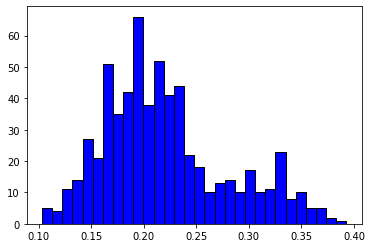

In [20]:
plt.hist(dist_rotated, color = 'blue', edgecolor = 'black',
         bins = int(150/5))


In [10]:
c = 0
dist_noises1 = []
path = "/content/drive/My Drive/Colab Notebooks/ALL DB"
for file in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB"):
    image = plt.imread(path + '/' + file)
    c+=1
    print(c)
    hash1 = image_to_hash(image,256,256,new_cols)
    images = []
    img_array = np.asarray(image)
    
    for var in range(5,10,1):
        image2 = random_noise(img_array,mode = 'gaussian',var=var/100)
        images.append(image2)
            
            
    for img in images:
        attacked_hash = image_to_hash(img,256,256,new_cols)
        dist_noises1.append(hamming_dist(hash1,attacked_hash))
      



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


(array([ 3.,  2.,  5.,  4.,  4., 10.,  4.,  3.,  8.,  7.,  8., 10.,  5.,
        11.,  2.,  3.,  7.,  4.,  2.,  3.,  3.,  3.,  7.,  2.,  6.,  2.,
         0.,  6.,  1.,  0.,  2.,  2.,  0.,  0.,  0.,  1.]),
 array([0.20238095, 0.20778219, 0.21318342, 0.21858466, 0.22398589,
        0.22938713, 0.23478836, 0.24018959, 0.24559083, 0.25099206,
        0.2563933 , 0.26179453, 0.26719577, 0.272597  , 0.27799824,
        0.28339947, 0.28880071, 0.29420194, 0.29960317, 0.30500441,
        0.31040564, 0.31580688, 0.32120811, 0.32660935, 0.33201058,
        0.33741182, 0.34281305, 0.34821429, 0.35361552, 0.35901675,
        0.36441799, 0.36981922, 0.37522046, 0.38062169, 0.38602293,
        0.39142416, 0.3968254 ]),
 <a list of 36 Patch objects>)

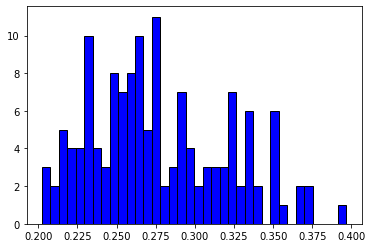

In [11]:
plt.hist(dist_noises1, color = 'blue', edgecolor = 'black',
         bins = int(180/5))


In [12]:
c = 0
dist_noises4 = []
path = "/content/drive/My Drive/Colab Notebooks/ALL DB"
for file in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB"):
    image = plt.imread(path + '/' + file)
    c+=1
    print(c)
    hash1 = image_to_hash(image,256,256,new_cols)
    images = []
    img_array = np.asarray(image)
    
    image2 = random_noise(img_array,mode = 'poisson')
    images.append(image2)
            
            
    for img in images:
        attacked_hash = image_to_hash(img,256,256,new_cols)
        dist_noises4.append(hamming_dist(hash1,attacked_hash))
      



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


(array([1., 0., 2., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 3.,
        0., 0., 3., 1., 0., 1., 3., 2., 2., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1.]),
 array([0.12698413, 0.13084215, 0.13470018, 0.1385582 , 0.14241623,
        0.14627425, 0.15013228, 0.1539903 , 0.15784832, 0.16170635,
        0.16556437, 0.1694224 , 0.17328042, 0.17713845, 0.18099647,
        0.1848545 , 0.18871252, 0.19257055, 0.19642857, 0.2002866 ,
        0.20414462, 0.20800265, 0.21186067, 0.21571869, 0.21957672,
        0.22343474, 0.22729277, 0.23115079, 0.23500882, 0.23886684,
        0.24272487, 0.24658289, 0.25044092, 0.25429894, 0.25815697,
        0.26201499, 0.26587302]),
 <a list of 36 Patch objects>)

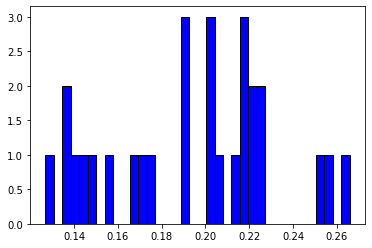

In [13]:
plt.hist(dist_noises4, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

In [14]:
c = 0
dist_noises2 = []
path = "/content/drive/My Drive/Colab Notebooks/ALL DB"
for file in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB"):
    image = plt.imread(path + '/' + file)
    c+=1
    print(c)
    hash1 = image_to_hash(image,256,256,new_cols)
    images = []
    img_array = np.asarray(image)
    
    for amount in range(1,11,1):
        image2 = salt_pepper(image,amount/10)
        images.append(image2)

    for img in images:
        attacked_hash = image_to_hash(img,256,256,new_cols)
        dist_noises2.append(hamming_dist(hash1,attacked_hash))

1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  from ipykernel import kernelapp as app


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


(array([ 1.,  0.,  3.,  4.,  0.,  3.,  1.,  3.,  2.,  6.,  7.,  6.,  8.,
         6., 11., 20., 20., 24., 22., 16., 22., 12., 15., 12., 18.,  9.,
         9.,  3.,  4.,  3.,  2.,  2.,  2.,  1.,  1.,  2.]),
 array([0.06349206, 0.07352293, 0.08355379, 0.09358466, 0.10361552,
        0.11364638, 0.12367725, 0.13370811, 0.14373898, 0.15376984,
        0.16380071, 0.17383157, 0.18386243, 0.1938933 , 0.20392416,
        0.21395503, 0.22398589, 0.23401675, 0.24404762, 0.25407848,
        0.26410935, 0.27414021, 0.28417108, 0.29420194, 0.3042328 ,
        0.31426367, 0.32429453, 0.3343254 , 0.34435626, 0.35438713,
        0.36441799, 0.37444885, 0.38447972, 0.39451058, 0.40454145,
        0.41457231, 0.42460317]),
 <a list of 36 Patch objects>)

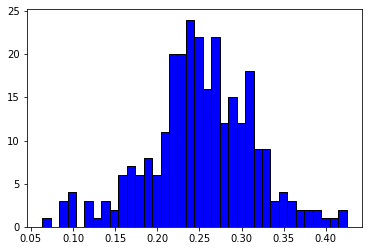

In [15]:
plt.hist(dist_noises2, color = 'blue', edgecolor = 'black',
         bins = int(180/5))


In [16]:
dist_diff = []
c = 0
path = "/content/drive/My Drive/Colab Notebooks/ALL DB"
for file in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB"):
    image = plt.imread(path + '/'+file)
    c+=1
    print(c)
    hash1 = image_to_hash(image,256,256,new_cols)
    for files in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB"):
        if(files==file):
            continue
        image1 = plt.imread(path + '/'+files)
        hash2 = image_to_hash(image1,256,256,new_cols)
        dist_diff.append(hamming_dist(hash1,hash2))
        ##print(hamming_dist(hash1,hash2))
        if(hamming_dist(hash1,hash2)==0.0):
           print(file)
           print(files)
           print('\n')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


(array([ 4.,  2.,  8.,  6., 14., 22., 30., 32., 52., 50., 84., 56., 56.,
        46., 48., 70., 26., 28., 12., 20., 36., 12.,  4.,  4.,  6.,  4.,
         6.,  0.,  4.,  4.,  0.,  6.,  0.,  0.,  2.,  2.]),
 array([0.23015873, 0.23886684, 0.24757496, 0.25628307, 0.26499118,
        0.27369929, 0.28240741, 0.29111552, 0.29982363, 0.30853175,
        0.31723986, 0.32594797, 0.33465608, 0.3433642 , 0.35207231,
        0.36078042, 0.36948854, 0.37819665, 0.38690476, 0.39561287,
        0.40432099, 0.4130291 , 0.42173721, 0.43044533, 0.43915344,
        0.44786155, 0.45656966, 0.46527778, 0.47398589, 0.482694  ,
        0.49140212, 0.50011023, 0.50881834, 0.51752646, 0.52623457,
        0.53494268, 0.54365079]),
 <a list of 36 Patch objects>)

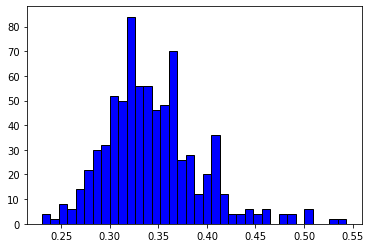

In [17]:
plt.hist(dist_diff, color = 'blue', edgecolor = 'black',
         bins = int(180/5))
